In [58]:
import pandas as pd

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn import svm
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import itertools
import pickle
%matplotlib inline

In [59]:
df = pd.read_csv('../data/raw/ds-jobs-train.csv')

In [60]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [61]:
ohe = OneHotEncoder()
le = LabelEncoder()
smote = SMOTE(random_state=42)

In [62]:
def handle_encoding(df: DataFrame) -> DataFrame:
  gender_map = {
        'Female': 2,
        'Male': 1,
        'Other': 0
         }

  relevent_experience_map = {
      'Has relevent experience':  1,
      'No relevent experience':    0
  }

  enrolled_university_map = {
      'no_enrollment'   :  0,
      'Full time course':    1, 
      'Part time course':    2 
  }
      
  education_level_map = {
      'Primary School' :    0,
      'Graduate'       :    2,
      'Masters'        :    3, 
      'High School'    :    1, 
      'Phd'            :    4
      } 
      
  major_map ={ 
      'STEM'                   :    0,
      'Business Degree'        :    1, 
      'Arts'                   :    2, 
      'Humanities'             :    3, 
      'No Major'               :    4, 
      'Other'                  :    5 
  }
      
  experience_map = {
      '<1'      :    0,
      '1'       :    1, 
      '2'       :    2, 
      '3'       :    3, 
      '4'       :    4, 
      '5'       :    5,
      '6'       :    6,
      '7'       :    7,
      '8'       :    8, 
      '9'       :    9, 
      '10'      :    10, 
      '11'      :    11,
      '12'      :    12,
      '13'      :    13, 
      '14'      :    14, 
      '15'      :    15, 
      '16'      :    16,
      '17'      :    17,
      '18'      :    18,
      '19'      :    19, 
      '20'      :    20, 
      '>20'     :    21
  } 
      
  company_type_map = {
      'Pvt Ltd'               :    0,
      'Funded Startup'        :    1, 
      'Early Stage Startup'   :    2, 
      'Other'                 :    3, 
      'Public Sector'         :    4, 
      'NGO'                   :    5
  }

  company_size_map = {
      '<10'          :    0,
      '10/49'        :    1, 
      '100-500'      :    2, 
      '1000-4999'    :    3, 
      '10000+'       :    4, 
      '50-99'        :    5, 
      '500-999'      :    6, 
      '5000-9999'    :    7
  }
      
  last_new_job_map = {
      'never'        :    0,
      '1'            :    1, 
      '2'            :    2, 
      '3'            :    3, 
      '4'            :    4, 
      '>4'           :    5
  }

  df.loc[:,'education_level'] = df['education_level'].map(education_level_map)
  df.loc[:,'company_size'] = df['company_size'].map(company_size_map)
  df.loc[:,'company_type'] = df['company_type'].map(company_type_map)
  df.loc[:,'last_new_job'] = df['last_new_job'].map(last_new_job_map)
  df.loc[:,'major_discipline'] = df['major_discipline'].map(major_map)
  df.loc[:,'enrolled_university'] = df['enrolled_university'].map(enrolled_university_map)
  df.loc[:,'relevent_experience'] = df['relevent_experience'].map(relevent_experience_map)
  df.loc[:,'gender'] = df['gender'].map(gender_map)
  df.loc[:,'experience'] = df['experience'].map(experience_map)

  df.loc[:, 'city'] = le.fit_transform(df.loc[:, 'city'])

  return df

In [63]:
def handle_missing_data(df: DataFrame) -> DataFrame:
  missing_cols = df.columns[df.isna().any()].tolist()

  df_missing = df[['enrollee_id'] + missing_cols]
  df_non_missing = df.drop(missing_cols, axis=1)

  knn_imputer = KNNImputer(n_neighbors=1)

  X = np.round(knn_imputer.fit_transform(df_missing))

  df_missing = pd.DataFrame(X, columns = df_missing.columns)

  df_merge = pd.merge(df_missing, df_non_missing, on='enrollee_id')

  return df_merge

In [64]:
def normalize_dataset(df):
  df = handle_encoding(df)
  df = handle_missing_data(df)

  return df

In [65]:
df_train_normalized = df.copy()
df_train_normalized = normalize_dataset(df_train_normalized)

In [66]:
numeric_data = ['city_development_index', 'training_hours']
categoric_data = ['relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size',
                  'company_type', 'last_new_job', 'gender']

In [67]:
transformers=[('cat_scale', OneHotEncoder(), categoric_data),
             ('num_scale', MinMaxScaler(), numeric_data)]

preprocessor = ColumnTransformer(transformers=transformers)

lgb = LGBMClassifier()

steps = [('preprocessor', preprocessor),
        ('lgb', lgb)]

lgb_model = Pipeline(steps=steps, verbose=1)
lgb_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_scale', OneHotEncoder(),
                                                  ['relevent_experience',
                                                   'enrolled_university',
                                                   'education_level',
                                                   'major_discipline',
                                                   'experience', 'company_size',
                                                   'company_type',
                                                   'last_new_job', 'gender']),
                                                 ('num_scale', MinMaxScaler(),
                                                  ['city_development_index',
                                                   'training_hours'])])),
                ('lgb', LGBMClassifier())],
         verbose=1)

In [68]:
df_train_normalized = df_train_normalized.astype({'relevent_experience': 'category', 'enrolled_university': 'category', 'education_level': 'category',
                        'major_discipline': 'category', 'experience': 'category', 'company_size': 'category', 'company_type': 'category',
                        'last_new_job': 'category', 'gender': 'category'})

In [69]:
X = df_train_normalized.drop(['enrollee_id', 'target'], axis = 1)
Y = df_train_normalized['target']

In [70]:
X_smote, Y_smote = smote.fit_resample(X, Y)

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(X_smote, Y_smote, test_size=0.3, random_state=42)

In [72]:
lgb_model.fit(X_train, Y_train)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing lgb, total=   0.3s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_scale', OneHotEncoder(),
                                                  ['relevent_experience',
                                                   'enrolled_university',
                                                   'education_level',
                                                   'major_discipline',
                                                   'experience', 'company_size',
                                                   'company_type',
                                                   'last_new_job', 'gender']),
                                                 ('num_scale', MinMaxScaler(),
                                                  ['city_development_index',
                                                   'training_hours'])])),
                ('lgb', LGBMClassifier())],
         verbose=1)

In [73]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [74]:
def print_results(y_pred, y_test, title='Results'):
  print(f'******* {title} *****')
  print(f'Classification Report: \n{classification_report(y_test, y_pred)}')
  print(f'Precision: {precision_score(y_test, y_pred)}')
  print(f'Recall: {recall_score(y_test, y_pred)}')
  print(f'F1 Score: {f1_score(y_test, y_pred)}')
  print(f'ROC AUC: {roc_auc_score(y_test, y_pred)}')

  plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=[0,1], title = title)

******* LightGBM with SMOTE *****
Classification Report: 
              precision    recall  f1-score   support

         0.0       0.82      0.90      0.86      4325
         1.0       0.89      0.81      0.85      4304

    accuracy                           0.85      8629
   macro avg       0.86      0.85      0.85      8629
weighted avg       0.86      0.85      0.85      8629

Precision: 0.8871008939974457
Recall: 0.8069237918215614
F1 Score: 0.845114977491179
ROC AUC: 0.8523636300148268


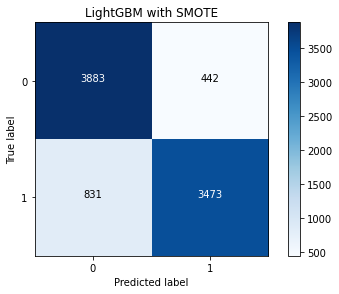

In [75]:
print_results(lgb_model.predict(X_test), Y_test, title='LightGBM with SMOTE')

In [76]:
file_name = "../models/model.pkl"
pickle.dump(lgb_model, open(file_name, "wb"))